In [ ]:
%matplotlib inline


Transfer Learning 5W1H
==========================
**Author**: `모파상 <https://yspaik.github.io>`_
**originated from**: `Sasank Chilamkurthy <https://chsasank.github.io>`

`cs231n notes <http://cs231n.github.io/transfer-learning/>`__


** What **: transfer learning이란 무엇인가  

    실제로, 충분한 크기의 데이터 세트를 갖는 것은 비교적 드물기 때문에, 전체 Convolutional
    네트워크를 처음부터 (무작위 초기화를 통해) 훈련시키는 사람은 거의 없습니다. 대신 매우 큰 
    데이터 세트 (예 : 1000 개의 카테고리가있는 120 만 개의 이미지를 포함하는 ImageNet)에서 
    ConvNet을 pretrain 한 다음 해당 작업에 대하여 튜닝하면서 사용하거나 또는 고정된 feature
    extractor 로 ConvNet을 사용합니다.

** When **: transfer learning을 사용하는 두가지 시나리오

-  **Finetuning the convnet**: scratch부터 초기 설정을 하는 대신 imagenet 1000 
    데이터 세트에서 train 받은 네트워크와 같은 pretrained 네트워크를 사용하여 네트워크를 
    초기화하고자 할때.
-  **ConvNet as fixed feature extractor**: 최종 fully connected layer를 제외한 
    모든 네트워크의 가중치를 고정하고자 할때. 이 마지막 fully connected layer는 랜덤 weight의 
    새 레이어로 대체되며 이 레이어 만 학습됩니다.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

1번째 경우: Fine Tuning
---------

Load Data
---------

데이터 로딩을 위해서 torchvision 과 torch.utils.data package를 사용합니다.

모델을 훈련 시켜서 **ants** 와 **bees** 를 분류합니다. train 용 120 개, evaluation 75개
이정도는  scratch 부터 하는 학습이라면 매우 작은 데이터 집합인데도 transfer learning을 사용하면 
합리적으로 일반화 할 수 있어야합니다.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


몇개의 이미지를 시각화
^^^^^^^^^^^^^^^^^^^^^^
train용 이미지를 몇개 시각화하여 데이터 augmentation을 이해합시다.

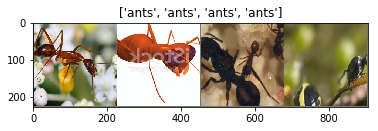

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

이제, model을 train하는 general 함수를 작성합니다. 여기서 보여줄 것은

-  learning rate 스케줄링하기
-  최적의 model 저장하기

입니다.

다음 코드에서 파라미터 ``scheduler`` 는 ``torch.optim.lr_scheduler``
에 있는 스케줄러입니다.



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

이 함수는 모델 예측을 시각화 합니다.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

몇 개의 이미지에 대한 예측 결과를 보여주는 일반 함수입니다. 

In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

pretrained model을 로드하고 final fully connected layer를 리셋합니다.




In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/keanu/.torch/models/resnet18-5c106cde.pth
100.0%


train하고 evaluate하기
^^^^^^^^^^^^^^^^^^

CPU일 경우 15-25 분 정도 걸리고 GPU를 이용하면 1분 미만이 걸립니다.



In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1684 Acc: 0.6639
val Loss: 0.0614 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.1515 Acc: 0.7623
val Loss: 0.1183 Acc: 0.8170

Epoch 2/24
----------
train Loss: 0.1412 Acc: 0.7746
val Loss: 0.0647 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.1021 Acc: 0.8238
val Loss: 0.0620 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.1083 Acc: 0.8238
val Loss: 0.0584 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.1570 Acc: 0.8279
val Loss: 0.0731 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.1034 Acc: 0.8279
val Loss: 0.1357 Acc: 0.7974

Epoch 7/24
----------
train Loss: 0.1019 Acc: 0.8443
val Loss: 0.0443 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.0853 Acc: 0.8607
val Loss: 0.0446 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.0926 Acc: 0.8402
val Loss: 0.0419 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.0932 Acc: 0.8730
val Loss: 0.0410 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0683 Acc: 0.8770
val Loss: 0.0358 Acc: 0.9477

Ep

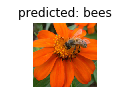

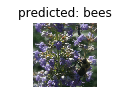

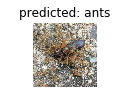

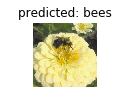

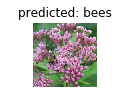

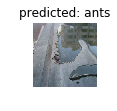

In [10]:
visualize_model(model_ft)

2번째 경우: ConvNet as fixed feature extractor
----------------------------------

마지막 layer를 빼고 모든 네트워크를 고정할 필요가 있습니다. ``requires_grad == False``으로 셋팅해서
파라미터를 고정하여 gradients가 ``backward()``에서 계산되지 않게 합니다.

여기에 대해서는 아래 문서에서 더 자세한 얘기를 살펴볼 수 있습니다.
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.


In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

학습 및 evaluate하기
^^^^^^^^^^^^^^^^^^

CPU로는 앞서 시나리오의 절반정도 시간이 걸립니다. 왜냐하면 대부분의 네트워크에서 gradient를 계산할 필요가 
없기 때문에 그렇습니다. 그러나 포워드는 계산되어야합니다.

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1469 Acc: 0.7254
val Loss: 0.2780 Acc: 0.5359

Epoch 1/24
----------
train Loss: 0.1391 Acc: 0.7582
val Loss: 0.0613 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.1472 Acc: 0.7787
val Loss: 0.0914 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.1445 Acc: 0.7746
val Loss: 0.0478 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.1166 Acc: 0.7992
val Loss: 0.0400 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.1233 Acc: 0.7828
val Loss: 0.0369 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.0854 Acc: 0.8443
val Loss: 0.1378 Acc: 0.8105

Epoch 7/24
----------
train Loss: 0.0912 Acc: 0.8402
val Loss: 0.0380 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.0978 Acc: 0.8279
val Loss: 0.0439 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.0779 Acc: 0.8607
val Loss: 0.0533 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.0891 Acc: 0.8402
val Loss: 0.0461 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0827 Acc: 0.8525
val Loss: 0.0423 Acc: 0.9542

Ep

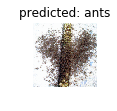

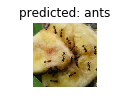

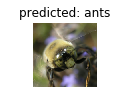

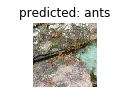

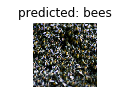

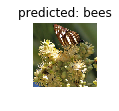

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()